In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE 
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

from nfmd.NFMD import NFMD
from utils import get_noise

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
##########################
##  Load the input data ##
##########################
numpts = 30000

# Load the forcing
file_stem = "./SimData/Outputs/"
f = np.load(file_stem+"input_force.npy")
f = f[:numpts]

# Load data from a simulated output for a single time constant
taus = [25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 50000, 100000, 500000, 1000000, 2500000]
taus = [100, 250, 500, 1000, 2500, 5000, 10000, 50000, 100000, 500000, 1000000]

# Define sampling frequency
fs = 10e6

# Create a time vector, define dt
tau = taus[0]
z = np.load(file_stem + "defl_{}ns.npy".format(tau))[:numpts]
n = z.shape[0]
t = np.linspace(0, n/fs, n)
dt = t[1]-t[0]

In [3]:
%%time
###############
# Nonstationary Fourier Mode Decomposition
###############

# Initialize results list:
results = {}

for tau in taus:
    print(tau, end = " | ")
    
    # Load in file and average trials
    fn = file_stem + "defl_{}ns.npy".format(tau)
    z = np.load(fn)[:numpts]
    z += get_noise(z, SNR=100)
    
    # Apply NFMD method:
    nfmd = NFMD(z.copy()/np.std(z)+1,
                num_freqs=2,
                window_size=30,
                optimizer_opts={'lr': 1e-04},
                max_iters=500,
                target_loss=1e-4)
    
    freqs, A, losses, indices = nfmd.decompose_signal()
    
    # Compute corrected results, and save them:
    n_freqs = nfmd.correct_frequencies(dt=dt)
    n_amps = nfmd.compute_amps()
    n_mean = nfmd.compute_mean()
    
    results[tau] = n_freqs, n_amps, n_mean, freqs, A, losses, indices


100 | 250 | 500 | 1000 | 2500 | 5000 | 10000 | 50000 | 100000 | 500000 | 1000000 | Wall time: 2min 17s


In [4]:
# Define functions to fit data against, using least squares:
tp = 0.001
fitfunc = lambda p, t: np.heaviside(t-tp,0.5)*p[0]*np.expm1(-(t-tp)/p[1]) # Target function
errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
p0 = [1, 25e-6] # Initial guess for the parameters

[-1.29063935e-10  1.40676853e-06] 1.0000000000000001e-07
[-1.29074366e-10  1.40676858e-06] 2.5000000000000004e-07
[-1.29070211e-10  1.40676898e-06] 5.000000000000001e-07
[-1.29041456e-10  1.40676915e-06] 1.0000000000000002e-06
[-1.29017968e-10  2.66182985e-06] 2.5e-06
[-1.29011801e-10  5.13822466e-06] 5e-06
[-1.29004700e-10  1.01254793e-05] 1e-05
[-1.28979807e-10  5.01323420e-05] 5e-05
[-1.28949824e-10  1.00144350e-04] 0.0001
[-1.28725810e-10  5.00276742e-04] 0.0005
[-1.28604079e-10  1.00096294e-03] 0.001


(-2e-11, 1.5e-10)

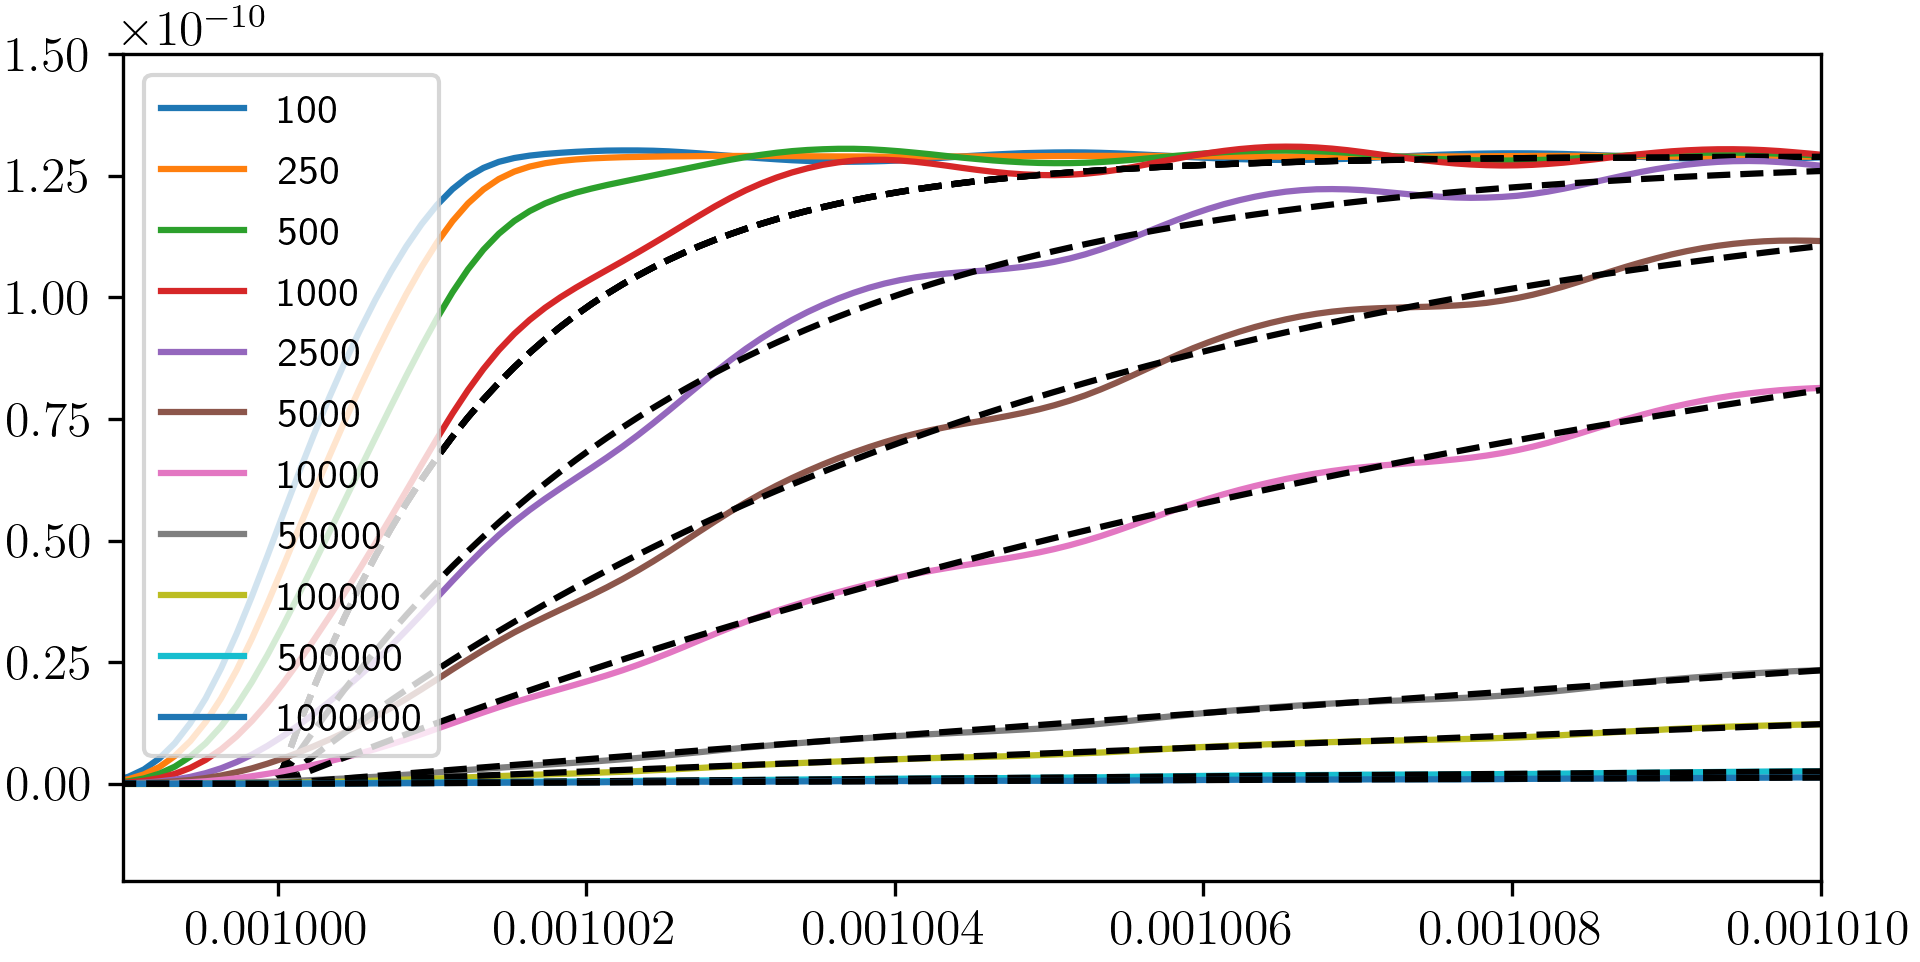

In [7]:
# Pull out the means, subtracting the '1' that was added to the signal
# Note: the added 1 to the signal improves detection of the mean, which otherwise may be considered 
# noise by the algorithm
means = [(1-results[tau][2])*np.std(z) for tau in taus]
t_mean = t[15:-14]

# Compute the fits, and predicted taus:
predicted_taus = []

for mean, tau in zip(means, taus):
    plt.plot(t_mean, mean, label=tau)
    
    p1, success = optimize.leastsq(errfunc, p0[:], args=(t_mean, mean))
    plt.plot(t, fitfunc(p1,t), '--k')
    
    print(p1, tau*1e-9)
    predicted_taus.append(p1[1])
    
    
plt.legend()
plt.xlim(0.000999,0.00101)
plt.ylim([-0.2e-10, 1.5e-10])

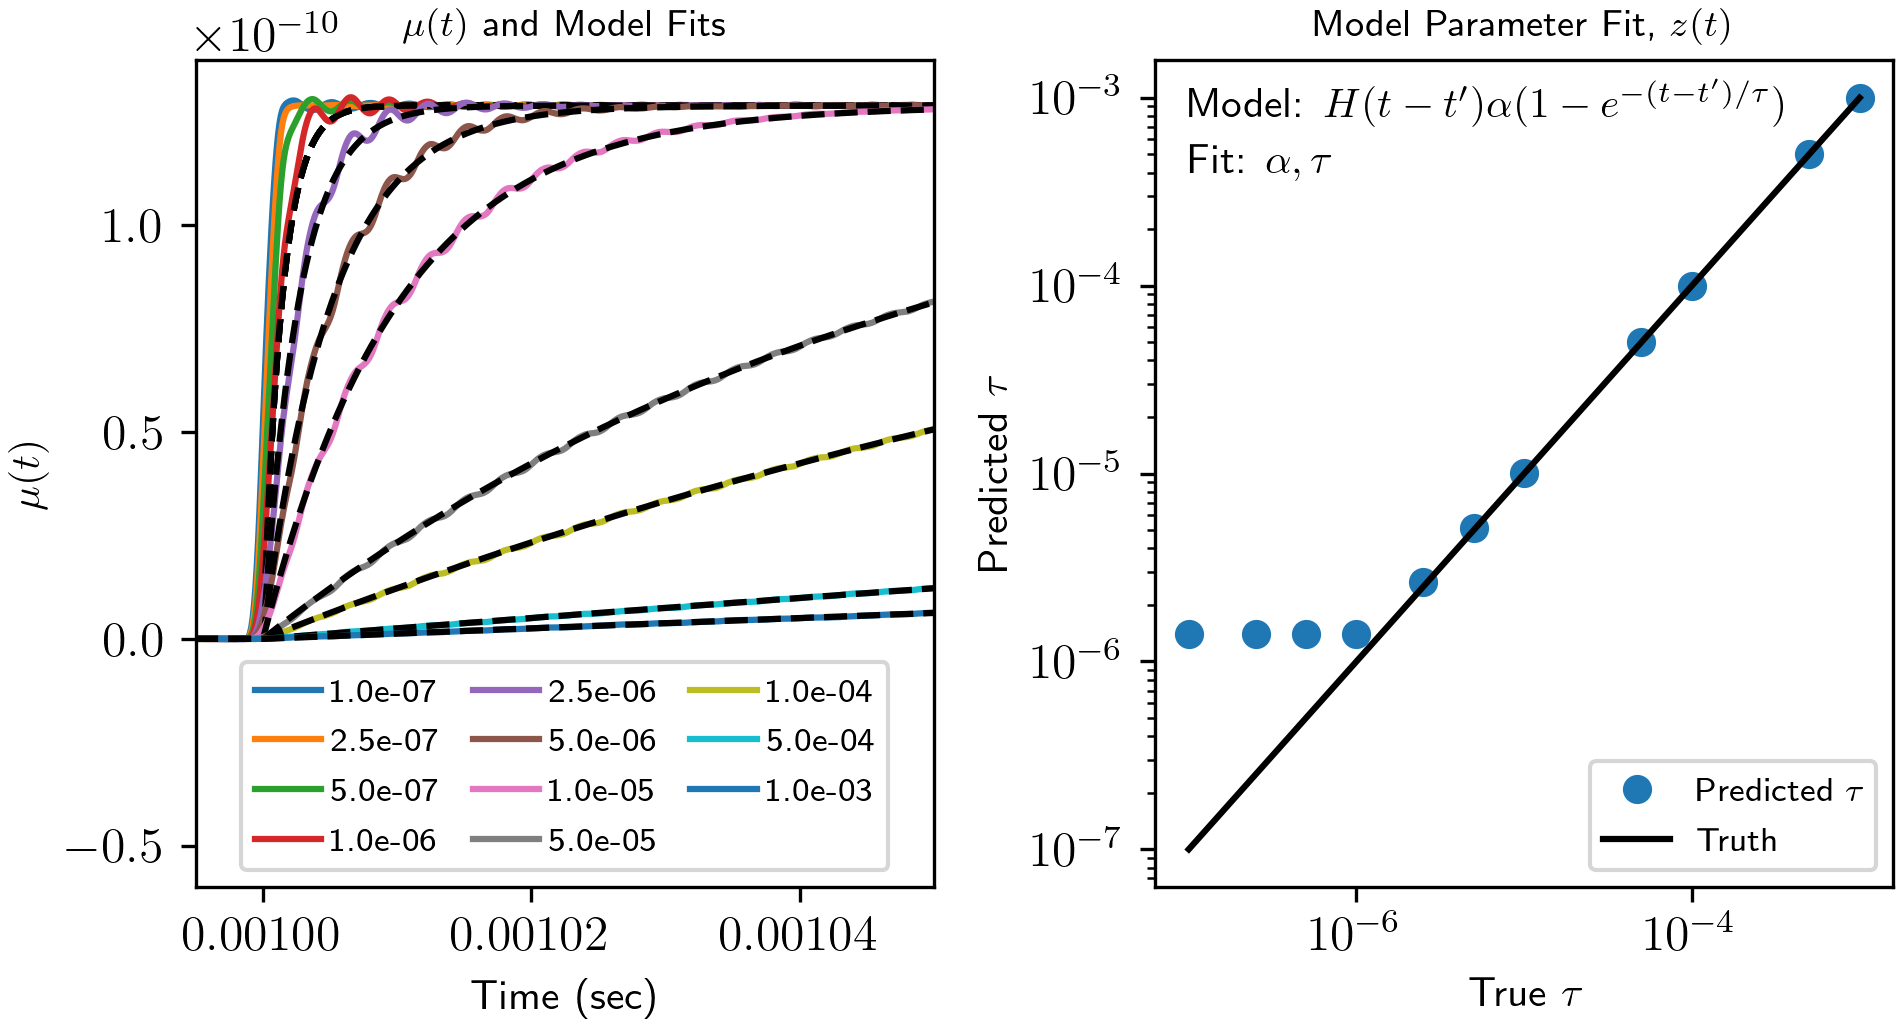

In [6]:
# compute the 'true' value of the taus, from the file name tau list
true_taus = np.asarray(taus)*1e-9

fig3 = plt.figure()
gs = fig3.add_gridspec(1, 2)

##############################
## Top Row -- Driving Force ##
##############################
ax1 = fig3.add_subplot(gs[0, 0])

for mean, tau in zip(means, taus):
    label = "{:.1e}".format(tau*1e-9)
    ax1.plot(t_mean, mean, label=label)
    
    p1, success = optimize.leastsq(errfunc, p0[:], args=(t_mean, mean))
    ax1.plot(t, fitfunc(p1,t), '--k')



ax2 = fig3.add_subplot(gs[0, 1])
ax2.loglog(true_taus, predicted_taus, 'o', label=r'Predicted $\tau$')
ax2.loglog(true_taus, true_taus, '-k', label='Truth')

# Put titles on the 3a and 3b columns
ax1.set_title('$\mu(t)$ and Model Fits', fontsize=9)
ax2.set_title('Model Parameter Fit, $z(t)$', fontsize=9)


################
## Formatting ##
################
ax1.set_xlim(0.000995,0.00105)
ax1.set_ylim([-0.6e-10,1.4e-10])
ax1.set_ylabel("$\mu(t)$")
ax1.set_xlabel("Time (sec)")

ax2.set_xlabel(r"True $\tau$")
ax2.set_ylabel(r"Predicted $\tau$")

ax1.legend(loc="lower center", ncol=3, handletextpad=0.3, columnspacing=1.0, fontsize=8)
ax2.legend(loc='lower right', fontsize=8)

model_text=r"Model: $H(t-t') \alpha (1-e^{-(t-t')/\tau})$"
param_text=r"Fit: $\alpha, \tau$"
ax2.text(1e-7,8e-4,model_text)
ax2.text(1e-7,4e-4,param_text)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

plt.savefig("Fig11.png")

plt.show()